
<h1><center>Trends In Forest Recovery After Stand Replacing Disturbance: A Spectrotemporal Evaluation Of Productivity In Southeastern Pine Forests</center></h1>

<h4><center> Daniel J. Putnam </center></h4>

<center> For partial fulfillment of the reqiurements for the Master of Science degree </center>
<center> College of Natural Resources and Environment </center>
<center> Virginia Polytechnic Institute and State University </center>


## Analysis Preperation

### _Libraries_

In [1]:
import geemap
import ee
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from palettable.colorbrewer.diverging import RdYlGn_11 as NDVIpalette
from palettable.colorbrewer.sequential import YlOrRd_9 as LCMSpalette
ee.Initialize()

### _Imports_

In [2]:
LS5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") # landsat 5
LS7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") # landsat 7
LS8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") # landsat 8
LCMS = ee.ImageCollection("USFS/GTAC/LCMS/v2020-5") # Landcover Change Monitoring System
NLCD_col = ee.ImageCollection("USGS/NLCD_RELEASES/2019_REL/NLCD") # national landcover Database
STATES = ee.FeatureCollection("TIGER/2018/States") # state polygon boundaries (probably don't need anymore)
ecoRegions = ee.FeatureCollection("EPA/Ecoregions/2013/L3") # EPA Ecoregions
loblolly = ee.FeatureCollection("users/dputnam21/USFS_loblollyRange") # USFS loblolly pine range within states of interest

### _Priliminary set-up_

In [3]:
# Expirementing with colorbrewer palettes
## palettes = ee.data.require('users/gena/packages:palettes') ## going to need to replace this section of code
#NDVIpalette = palettes.colorbrewer.RdYlGn[9]
#LCMSpalette = palettes.colorbrewer.YlOrRd[9]

# Creating sample date range for disturbances
startingD = ee.Date.fromYMD(1995,1,1)
endingD = ee.Date.fromYMD(2010,12,31)

### _Landsat Preprocessing_

In [4]:
# Cloud masking based on the QA band : code taken from landsat example in data catalog in EE
def LScloudMask(image):
  qa = image.select('pixel_qa')
    # removing cloud pixels if confiance is high, cloud shadow, snow
  cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)) \
            .Or(qa.bitwiseAnd(1 << 3)) \
            .Or(qa.bitwiseAnd(1 << 4))
  return image.updateMask(cloud.Not())

# Going to try removing the coverage overlap between LS5 and LS8 to try and fix some issues
#LS5 = LS5.filterDate(start = '1984-01-01',opt_end = ee.Date('2013-04-11'))
#LS8 = LS8.filterDate(start = ee.Date('2013-04-11'))

# Lansat 5/7 & 8 differ in their band labeling, need to select the bands I'm going to use and rename them to
# match each other before merging collections : bands I need [red,green,NIR,SWIR1,SWIR2]    
LS8BandNames = ee.List(['B4','B3','B5','B6','B7','pixel_qa'])
NewBandNames = ee.List(['B3','B2','B4','B5','B7','pixel_qa'])
LS8 = LS8.select(LS8BandNames,NewBandNames)

# Adding a function to calculate and add an NDVI band for a single image
def addNDVI(image):
  ndvi = image.normalizedDifference(['B4', 'B3']).rename('NDVI')
  return image.addBands(ndvi)

# Adding a function to calculate and add an NBR band for a single image.
def addNBR(image):
  nbr = image.normalizedDifference(['B4', 'B7']).rename('NBR')
  return image.addBands(nbr)

# Adding a function to calculate and add an MBI band for a single image.
def addMBI(image):
  MBI = image.expression(
  "MBI = ((b('B5') - b('B7') - b('B4')) / (b('B5') + b('B7') + b('B4'))) + 0.5")
  return image.addBands(MBI)

# adding the cloud mask per generation
LS5 = LS5.map(LScloudMask)
LS7 = LS7.map(LScloudMask)
LS8 = LS8.map(LScloudMask)

# merging the landsat 5 and 7 collections
LS_stack = LS5.merge(LS8)
LS_stack = LS_stack.merge(LS7)

# data reduction on the image stack
LS_stack = LS_stack.filterBounds(loblolly)

# Adding the indices to the filtered combined Landsat collection
LS_stack_wVI = LS_stack.map(addNDVI)
LS_stack_wVI = LS_stack_wVI.map(addNBR)
LS_stack_wVI = LS_stack_wVI.map(addMBI)

---

## Stand Identification Methods

### _Landcover/Landuse Mask_

In [5]:
# New NLCD/LCMS method
# retrieve NLCD for each year
NLCD_2001 = NLCD_col.filter(ee.Filter.eq('system:index', '2001')).first().select("landcover")
NLCD_2004 = NLCD_col.filter(ee.Filter.eq('system:index', '2004')).first().select("landcover")
NLCD_2006 = NLCD_col.filter(ee.Filter.eq('system:index', '2006')).first().select("landcover")
NLCD_2008 = NLCD_col.filter(ee.Filter.eq('system:index', '2008')).first().select("landcover")
NLCD_2011 = NLCD_col.filter(ee.Filter.eq('system:index', '2011')).first().select("landcover")
NLCD_2013 = NLCD_col.filter(ee.Filter.eq('system:index', '2013')).first().select("landcover")
NLCD_2016 = NLCD_col.filter(ee.Filter.eq('system:index', '2016')).first().select("landcover")
NLCD_2019 = NLCD_col.filter(ee.Filter.eq('system:index', '2019')).first().select("landcover")

# combine NLCD to image collection
NLCDlandcover_col = ee.ImageCollection(ee.List([NLCD_2001,NLCD_2004,NLCD_2006,NLCD_2008,NLCD_2011,NLCD_2013,NLCD_2016,NLCD_2019]))

# Function to remap NLCD classes of interest for conditional layer
def remapNLCD(image):
    image = ee.Image(image)
    image = image.updateMask(ee.Image.constant(42).Or(ee.Image.constant(52)))
    image = image.remap(ee.List([42,52]),ee.List([10,1]),defaultValue = None)
    return image

# Layer containing the summed values of pixels across the collection after remapping
NLCDclassSum = NLCDlandcover_col.map(remapNLCD).reduce(ee.Reducer.sum())
NLCDMask = NLCDclassSum.remap(ee.List([53,62,71,80]),ee.List([1,1,1,1]), defaultValue = None)

# retrieve LCMS landuse classification
LCMSlanduseCol = LCMS.select("Land_Use")

# A function to select only forest landuse class
def remapLCMS(image):
    image = ee.Image(image)
    onlyForest = image.remap([3],[1], defaultValue = None)
    return onlyForest

LCMSlanduseSum = LCMSlanduseCol.map(remapLCMS).reduce(ee.Reducer.sum())

# # combining the two layers into a mask
landCoverMask = NLCDMask.updateMask(LCMSlanduseSum.gte(35))
landCoverMask = landCoverMask.clip(loblolly) # clip mask to study boundaries for better loading

### _LCMS Fast change method_

In [6]:
# Using the LCMS Change metric to identify harvest areas in contrast to the max VI method
# Filtering LCMS for the region and timeframe
LCMSchange = LCMS.select('Change_Raw_Probability_Fast_Loss')
LCMSchange = LCMSchange.filterDate(startingD,endingD)

def LCMSchangeSelection(image):
    image = ee.Image(image)
    minConfidence = 51
    gtePercent = image.gte(ee.Image.constant(minConfidence))
    gtePercent = gtePercent.updateMask(gtePercent.eq(1))
    gtePercent = gtePercent.set({'year':image.date().get('year')})
    outImage = gtePercent.updateMask(landCoverMask).rename('remapped')
    return outImage

# applying the function to the LCMS
FC_stack = LCMSchange.map(LCMSchangeSelection)

### _Connected Pixel (Min stand size) mask_

In [7]:
# function to apply a connected pixel mask to the input image
def conectPixls(InImage,minArea,maxPixels):
    pixelCount = InImage.connectedPixelCount(maxPixels,False)
    minPixelCount = ee.Image(minArea).divide(ee.Image.pixelArea())
    outImage = InImage.updateMask(pixelCount.gte(minPixelCount))
    return outImage

# a function to be mapped accross an image collection and annually apply the connected pixels mask, also creates an
# additional band to store the year of disturbance for each pixel
def annualConectPixls(image):
    conectPixlsMasked = conectPixls(image,49500,1024) # minimum stand size of 5 hectares, maximum of 92 (tool limit)
    imgYear = image.get('year')
    imgYearBand = ee.Image.constant(imgYear).uint16().rename('ChangeY')
    imgYearBand = imgYearBand.updateMask(conectPixlsMasked)
    return conectPixlsMasked.addBands(imgYearBand)

FC_final = FC_stack.map(annualConectPixls)

In [8]:
# creating the summary images
FC_final_changeN = FC_final.select('remapped').reduce(ee.Reducer.sum())
FC_final_1stYear = FC_final.select('ChangeY').reduce(ee.Reducer.min())

---

## Automatic Stand Selection Method

### _Creating Sampling Areas Using Ecoregions_

In [9]:
# Limit ecoregions by overlap with loblolly range
loblollyEcoRegions = ecoRegions.filterBounds(loblolly)

# Function to convert the ecoregion code to an integer value
def convertPropertyToBand(feat):
    feat = ee.Feature(feat)
    prop = feat.get('us_l3code')
    propInt = ee.Number.parse(prop).toInt()
    feat = feat.set({'numericL3ecocode':propInt})
    return feat
loblollyEcoRegions = loblollyEcoRegions.map(convertPropertyToBand)

# Need to convert ecoregion feature collection and the property to integer in order for it to be used 
#     as the 'classBand' in the stratifiedSample fucntion
ecoregionImage = ee.Image(loblollyEcoRegions.reduceToImage(['numericL3ecocode'],ee.Reducer.first()))
ecoregionImage = ecoregionImage.cast({'first':'int8'})
ecoregionImage = ecoregionImage.clipToCollection(loblolly)

# An image representing pixels that are fast change and meet the landcover reqiurements
potentialSamples = ee.Image.toUint8(FC_final_changeN.updateMask(FC_final_changeN.lte(2)))

# Adding ecoregion code as band to potential sample pixels
potentialSamples = potentialSamples.addBands(ecoregionImage.select('first').rename('numericL3ecocode'))

### _Creating Random Sample Points_

In [10]:
# Going to try just using the export table function to drive
samplePoints = potentialSamples.stratifiedSample(numPoints = 50,
                                                 region = loblolly,
                                                 classBand = 'numericL3ecocode',
                                                 scale = 30,
                                                 seed = 5,
                                                 dropNulls = True,
                                                 geometries = True,
                                                 )

### _Imports/Exports of Created Data_

In [ ]:
# Exporting the points created in the above cell to google drive (only way they will finish processing)
# The export process will take about 15 minutes to complete
geemap.ee_export_vector_to_drive(samplePoints, 'stratifiedSamplePoints', 'EarthEngine_Exports', file_format='shp', selectors=None)

In [ ]:
# # Importing the points created in the above cell
# samplePoints = ee.FeatureCollection('users/dputnam21/stratifiedSamplePoints_03022022')

In [15]:
# Importing points created in arcpro
samplePoints = ee.FeatureCollection('users/dputnam21/revisedSamplePoints')

In [ ]:
# Exporting to google drive the NLCD/LCMS masked LCMS fast change summary layer
geemap.ee_export_image_to_drive(potentialSamples.select('remapped_sum'), description='revisedPotentialSamples',region = loblolly.geometry(), folder='EarthEngine_Exports', scale=30)

---

### Displaying images on the map

In [12]:
# LCMS landcover palette
LCMSlcPalette = ['efff6b','ff2ff8','1b9d0c','97ffff','a1a1a1','c2b34a','1B1716']

Map = geemap.Map()
Map.centerObject(loblolly,7)

# This is the bottom of the layer order

Map.addLayer(ecoregionImage.select('first'), vis_params = {'palette': LCMSlcPalette, 'min': 45, 'max':75}, name = 'Ecoregion Code Image')
Map.addLayer(landCoverMask, vis_params = {'palette': ['00441b'],'min':1,'max':1}, name = 'new landcover mask', shown = False)
Map.addLayer(FC_final_changeN,{'palette':['fee0d2','fc9272','de2d26'],'min':1,'max':5},'LCMS Fast Change Count',False)
Map.addLayer(FC_final_1stYear,{'palette':['edf8b1','7fcdbb','2c7fb8'],'min' : 1995, 'max' : 2010},'LCMS Fast Change Year',False)
Map.addLayer(potentialSamples.select('remapped_sum'),{'palette':['fee0d2','fc9272','de2d26'],'min':0,'max':2}, name = 'Potential Sample Pixels', shown = False)
Map.addLayer(samplePoints,{'color':'red'}, name = 'Stratified Random Samples')
# Map.addLayer(NLCDclassSum,vis_params = {'palette':['edf8e9','bae4b3','74c476','31a354','006d2c'],'min':0,'max':80})
Map.addLayer(NLCDMask)

# This is the top of the layer order
Map.addLayerControl()
Map

Map(center=[33.55547594326177, -83.81053005836175], controls=(WidgetControl(options=['position', 'transparent_…

### Export of stand attributes

In [ ]:
# adding unique ID to each point

# Adding environmental variables as attributes for each stand


### New compositing method

In [17]:
# enter analysis parameters
compositeMonthN = 11
outputIndex = 'NBR'
compositeStat = 'median'

# prep for function
chart_VI = LS_stack_wVI.filter(ee.Filter.calendarRange(compositeMonthN,compositeMonthN,'month'));

years = ee.List.sequence(1984, 2020)

In [18]:
from datetime import datetime

start = datetime.now() # figuring out how long this takes to run

def perFeatureValueExtraction(index,comMonth,vegIndex,comStat) :
    
    aFeature = ee.Feature(samplePoints.filter(ee.Filter.eq('UniqueID', index)).first())
    inFeature = aFeature.geometry()

    local_chart_VI = chart_VI.filterBounds(inFeature)

    # A function to be mapped over a feature colllection, extracts 37 index values for each feature, returns them as a
    def seasonalReduction_extraction (y):
        filteredColl = local_chart_VI.filter(ee.Filter.calendarRange(y, y, 'year'))
        singleImage = filteredColl.select(['NDVI','NBR','MBI']).reduce(ee.Reducer.median()) ## CHANGE COMPOSITE STAT HERE ###
        outputImage = singleImage.set('system:time_start', ee.Date.fromYMD(y,comMonth, 1).millis())
        valDict = outputImage.reduceRegion(reducer = ee.Reducer.mean(), geometry = inFeature, scale = 30)
        NBRval = ee.Number(valDict.get(ee.String(vegIndex+'_'+compositeStat),defaultValue = 0.0))
        return ee.List([NBRval, 0.0]).reduce(ee.Reducer.firstNonNull())

    outputList = ee.List(years.map(seasonalReduction_extraction,False)).getInfo()
    return outputList

# calling the function
NumPlots = samplePoints.size().getInfo()
ListOfValLists = []

for index in range(NumPlots) :
    #aFeature = ee.Feature(samplePoints.filter(ee.Filter.eq('system:index', 0)).first())
    aList = perFeatureValueExtraction(index,compositeMonthN,outputIndex,compositeStat)
    ListOfValLists.append(aList)
    
end = datetime.now() # effectively ending the timer
duration = end - start

# nicely printing the ellapsed time
timeList = str(duration).split(':')
print('The time elapsed during this execution of this operation was :','\n',
     timeList[0],'Hour(s)','\n',
     timeList[1],'Minute(s)','\n',
      'and',round(float(timeList[2]),ndigits = 0),'Seconds'
     )

# nicely displaying the raw data
standNum = 0
for alist in ListOfValLists :
    print('Stand',standNum,'\n',alist,'\n',('-'*124))
    standNum += 1

this function took this long to run : 0:27:13.326381 

The time elapsed during this execution of this operation was : 
 0 Hour(s) 
 27 Minute(s) 
 and 13.0 Seconds
Stand 0 
 [0.5691868662834167, 0.5125875473022461, 0, 0.5538530945777893, 0.5178415775299072, 0, 0.541412353515625, 0.4788059592247009, 0, 0.4860794246196747, 0.23273196816444397, 0.035087719559669495, 0.10576386749744415, 0.22648194432258606, 0.31207653880119324, 0.4943596422672272, 0.5788938403129578, 0.6073218584060669, 0.6739159226417542, 0.7339246273040771, 0.7363865971565247, 0.6992171406745911, 0.7983666062355042, 0.7093899250030518, 0.7322167158126831, 0.7146010994911194, 0.750885009765625, 0.7393671870231628, 0.7765910029411316, 0.6958934664726257, 0.626061201095581, 0.6740282773971558, 0.7374392151832581, 0.6933201551437378, 0.7483803033828735, 0.7844836711883545, 0.7050359845161438] 
 ----------------------------------------------------------------------------------------------------------------------------
Stand 

In [20]:
# creating arrays for rows and columns of the table
stand_nums = range(0,samplePoints.size().getInfo())
imageYears = years.getInfo()
numYears = years.size().getInfo()

# client side replacement of null value (0.0) with null object
NDVIvals = ListOfValLists
for i in range(0,len(NDVIvals)):
    for i2 in range(0,numYears) :
        if NDVIvals[i][i2] == 0 :
            NDVIvals[i][i2] = None

In [21]:
# Creating the dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

NDVItsDF = pd.DataFrame(index = stand_nums, columns = imageYears)
valIndex = 0
for r in range(0,len(stand_nums)):
    for c in range(0,len(imageYears)):
        NDVItsDF.iloc[r,c] = NDVIvals[r][c]
        valIndex += 1
        
for col in NDVItsDF:
    NDVItsDF[col] = pd.to_numeric(NDVItsDF[col], errors='coerce')
NDVItsDF

,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0.569187,0.512588,NaN,0.553853,0.517842,NaN,0.541412,0.478806,NaN,0.486079,0.232732,0.035088,0.105764,0.226482,0.312077,0.494360,0.578894,0.607322,0.673916,0.733925,0.736387,0.699217,0.798367,0.709390,0.732217,0.714601,0.750885,0.739367,0.776591,0.695893,0.626061,0.674028,0.737439,0.693320,0.748380,0.784484,0.705036
1,NaN,NaN,NaN,NaN,0.594312,NaN,0.618781,NaN,NaN,NaN,0.551878,-0.262348,-0.118503,-0.111932,0.167702,0.430076,0.701936,0.724042,NaN,0.799917,0.790355,0.759431,0.770089,0.720706,0.775375,0.748355,0.706054,0.791707,NaN,0.492671,0.540942,0.546342,0.649558,0.695407,0.687625,0.707060,0.662021
2,0.547827,NaN,0.539711,0.517037,0.517644,0.580591,0.493063,0.503166,0.551984,0.469937,0.528525,0.471510,0.536481,0.681693,0.242685,0.344735,0.412727,0.515602,0.602170,0.461016,0.559141,0.636386,0.508557,NaN,0.547631,0.536348,0.540182,0.621014,0.592369,0.575781,0.600373,0.573815,0.651554,0.627385,0.597751,0.634974,0.658275
3,0.683056,0.708706,NaN,0.688581,0.529585,NaN,0.665354,0.635305,NaN,0.611212,0.615397,0.426616,-0.116930,0.034640,0.005536,0.231792,0.402953,0.534748,0.582238,0.794891,0.816713,0.782562,0.753376,0.781867,0.820895,0.720810,0.786667,0.775322,0.740402,0.580957,0.729354,0.550218,0.609968,0.633126,0.652695,0.622572,0.634650
4,NaN,NaN,NaN,0.316859,0.361668,NaN,NaN,NaN,NaN,0.269409,0.371407,0.396583,0.316290,0.378253,0.230844,0.228178,0.329786,0.392543,0.684349,0.565679,0.563492,0.600641,0.470988,0.668845,0.571381,0.561473,0.547692,0.597905,NaN,NaN,0.504804,0.481195,0.576274,0.597305,0.506643,0.560348,0.515551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,0.750598,0.743687,0.599721,0.815324,0.853596,0.789578,0.758242,0.719655,0.773892,0.710125,0.820823,0.763183,0.749484,0.162926,0.316276,0.249547,0.391871,0.451240,0.592319,0.570342,0.609266,0.701899,0.665989,0.662880,0.688716,0.733628,0.698355,0.750076,0.725723,0.709165,0.758476,0.729376,0.714895,0.652901,0.722240,0.713320,0.633974
515,NaN,0.772329,NaN,NaN,0.684451,NaN,0.688474,NaN,0.659574,NaN,0.690169,0.815077,0.570625,NaN,0.205201,-0.012357,0.258041,0.456797,0.570984,0.587691,0.400959,0.368135,0.478295,0.528510,0.575260,0.648661,0.636287,0.615606,0.680591,0.690705,0.704849,0.665278,0.688223,0.716163,NaN,0.663661,0.686749
516,NaN,NaN,NaN,NaN,0.746613,NaN,0.710355,NaN,0.754510,NaN,0.710020,0.072913,NaN,0.436570,0.539597,0.538992,0.657287,0.766980,0.787274,0.723107,0.607665,0.518533,0.597975,0.596121,0.716831,0.669833,0.563959,0.568711,0.596264,0.641550,0.691242,0.583483,0.679064,0.706320,0.714727,0.703070,0.711712
517,NaN,NaN,NaN,NaN,0.630961,NaN,0.619039,NaN,0.635563,NaN,0.516987,0.656116,NaN,0.417070,0.170917,0.149986,0.312728,0.398354,0.466023,0.402460,0.523358,0.506215,0.310534,0.410831,0.336042,0.469246,0.441025,0.614195,0.628640,0.448320,0.534621,0.544934,0.616818,0.608862,0.320383,0.661552,0.664299


### Creating time series plots

Text(0.06, 0.5, 'NBR value')

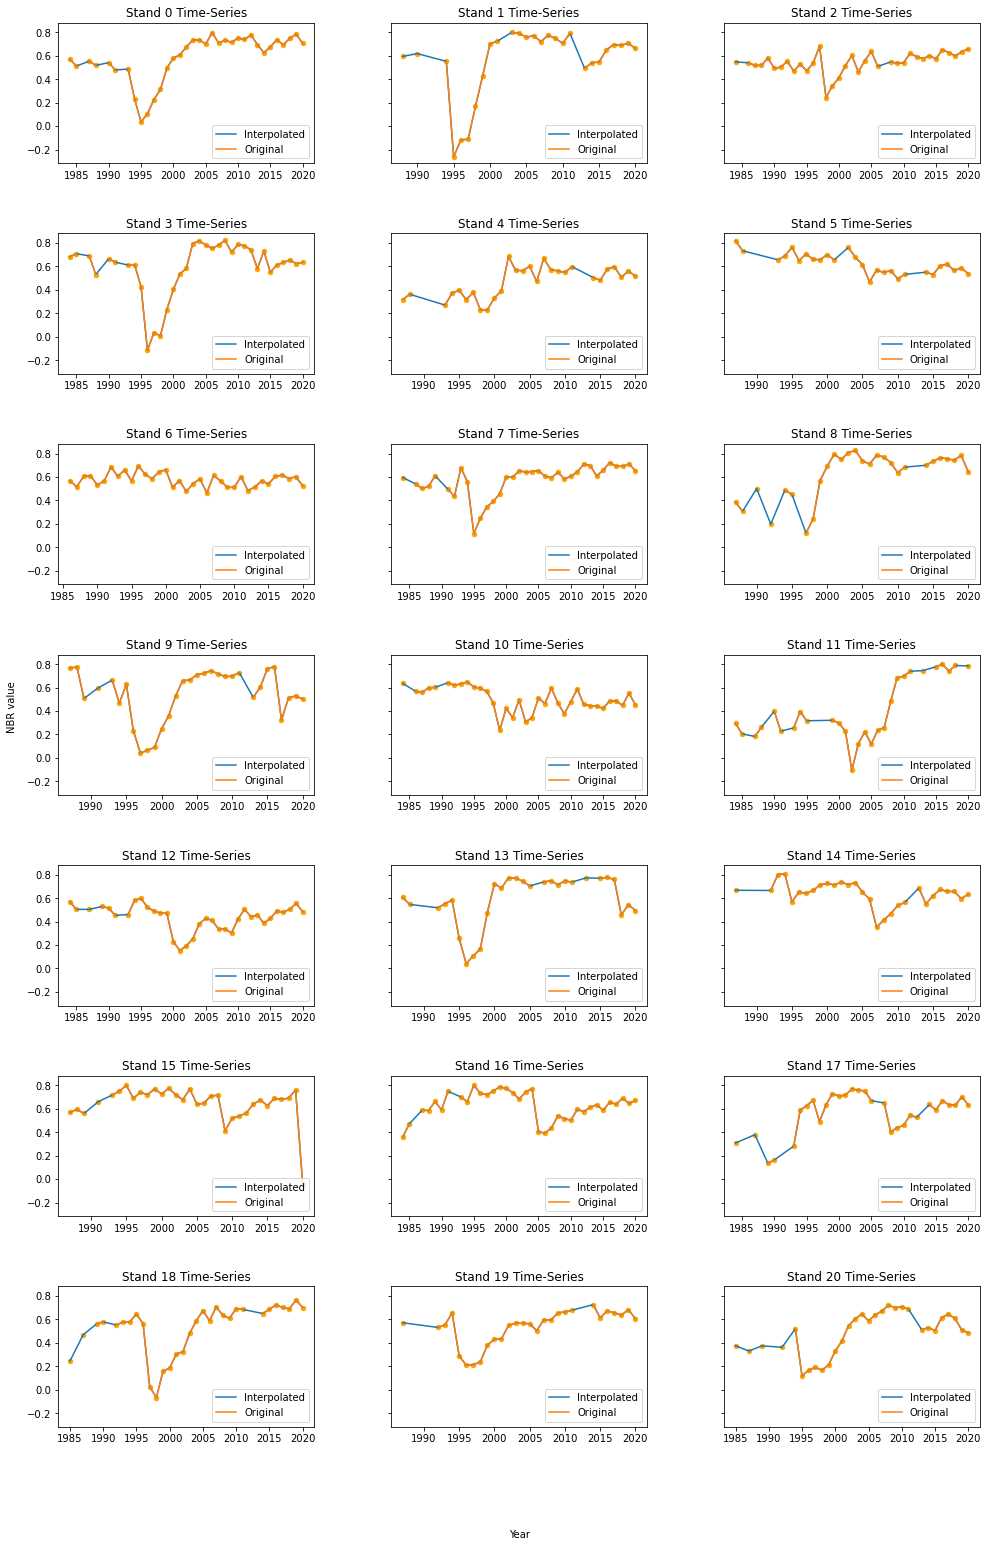

In [22]:
%matplotlib inline
import scipy as sp
import scipy.signal as scisig

# interpolation of null values
plotDF = NDVItsDF.interpolate(axis = 'columns',method = 'linear')

# setting up for time-series plots
fig, axs = plt.subplots(7, 3, sharex=False, sharey=True, figsize = (16,25))

for i, ax in enumerate(fig.axes):
    ax.plot(plotDF.iloc[i,].transpose(),label = "Interpolated")
    ax.plot(NDVItsDF.iloc[i,].transpose(),label = "Original")
    ax.scatter(imageYears,NDVItsDF.iloc[i,], color = 'orange',s = 20)
    ax.legend(loc='lower right')
    ax.set_title("Stand"+' '+str(i)+' '+"Time-Series")
    
fig.subplots_adjust(left=0.1, bottom=0.1, right=None, top=None, wspace=0.3, hspace=0.5)
fig.text(0.5, 0.04, 'Year', ha='center', va='center')
fig.text(0.06, 0.5, (outputIndex+' '+'value'), ha='center', va='center', rotation='vertical')

In [23]:
plotDF

plotDF.to_csv(path_or_buf="C:/R_workspace/timeSeriesDF500_2.csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')